In [ ]:
## In this implementation, the ARIMA Model is used to predict the closing stock price of NASDAQ:NVDA from 24 October to 4 November (inclusive)

In [1]:
## Importing Libraries
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# Get stock prices from yahoo
df = web.DataReader('NVDA', data_source = 'yahoo', start = '2016-01-01', end = '2022-10-22')

# Display data
df 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-31,8.372500,8.240000,8.335000,8.240000,14852800.0,8.049901
2016-01-04,8.145000,8.010000,8.072500,8.092500,35807600.0,7.905805
2016-01-05,8.360000,8.125000,8.245000,8.222500,49027200.0,8.032806
2016-01-06,8.125000,7.790000,8.087500,7.882500,44934400.0,7.700647
2016-01-07,7.737500,7.470000,7.685000,7.570000,64530400.0,7.395360
...,...,...,...,...,...,...
2022-10-17,119.480003,115.169998,115.180000,118.879997,58077400.0,118.879997
2022-10-18,124.919998,116.180000,123.440002,119.669998,65936200.0,119.669998
2022-10-19,123.500000,118.339996,118.790001,120.510002,52313100.0,120.510002


In [3]:
# Get num rows and columns in data
df.shape

(1715, 6)

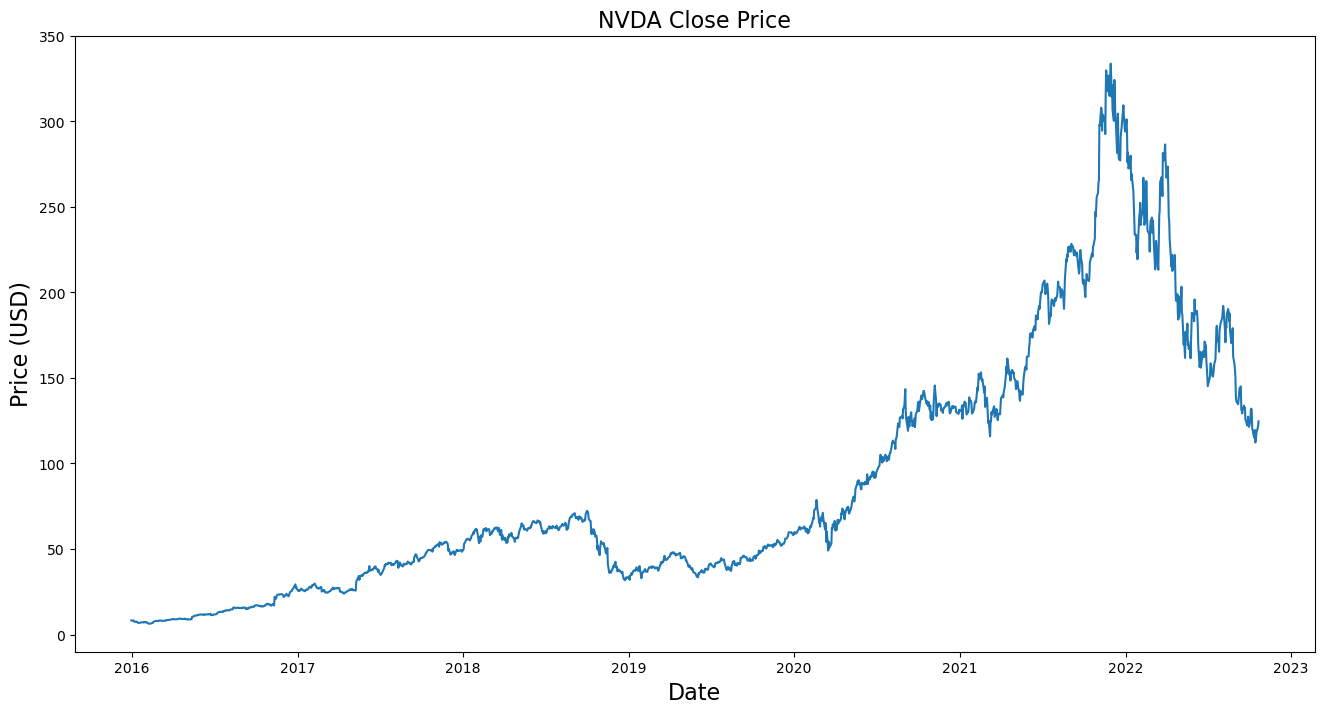

In [4]:
# Visualise the closing price data over time (from Yahoo Finance)
plt.figure(figsize=(16,8)) 
plt.title('NVDA Close Price', fontsize=16)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Price (USD)', fontsize = 16)
plt.show()


In [5]:
closing_data = df['Close']

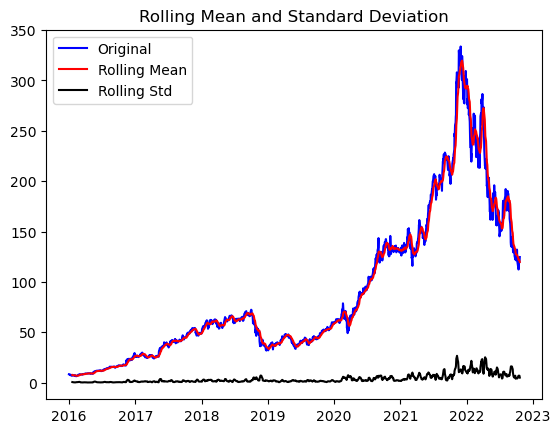

Results of dickey fuller test
Test Statistics                  -1.345698
p-value                           0.608015
No. of lags used                 21.000000
Number of observations used    1693.000000
critical value (1%)              -3.434218
critical value (5%)              -2.863249
critical value (10%)             -2.567680
dtype: float64


In [6]:
# Test for staionarity using the Augmented Dickey-Fuller (ADF) test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(closing_data)

In [7]:
## Based on the above statistic, we can see that p-value = 0.622 > 0.05 which means we are unable to reject the null hypothesis
## that our series is non-stationary. 

## Moving forward, we would like to isolate the time series from its trend and seasonality to do our analysis

<Figure size 640x480 with 0 Axes>

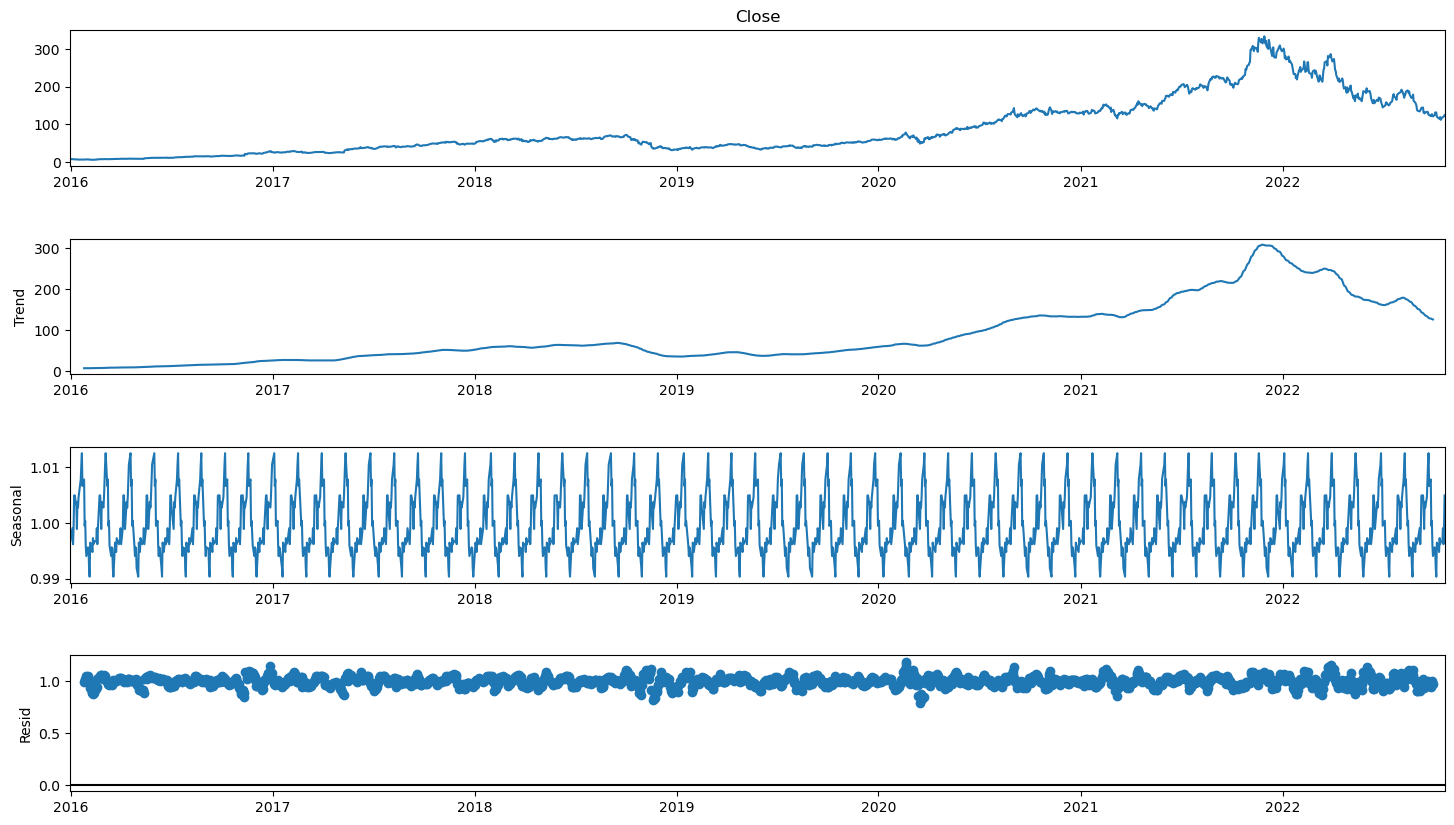

In [7]:
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(closing_data, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


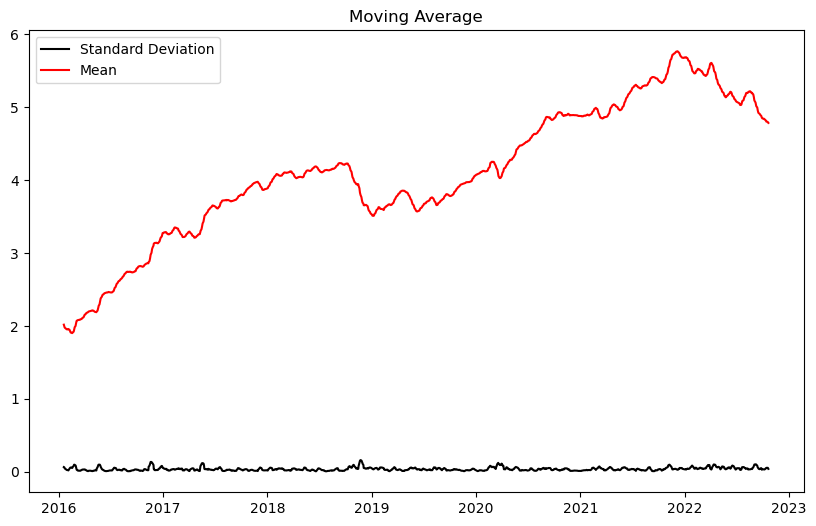

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
log_data = np.log(closing_data)
moving_avg = log_data.rolling(12).mean()
std_dev = log_data.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

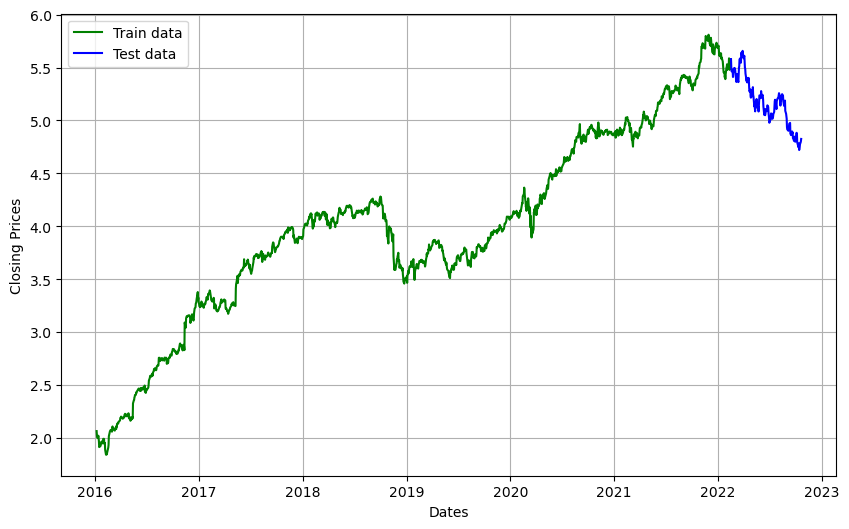

In [9]:
train_data, test_data = log_data[3:int(len(log_data)*0.9)], log_data[int(len(log_data)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9561.367, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9569.145, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9567.166, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9566.950, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9567.654, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9564.065, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9563.795, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9565.798, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9565.418, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9568.495, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9567.411, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9565.621, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9558.731, Time=1.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9557.916, Time=0.93 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

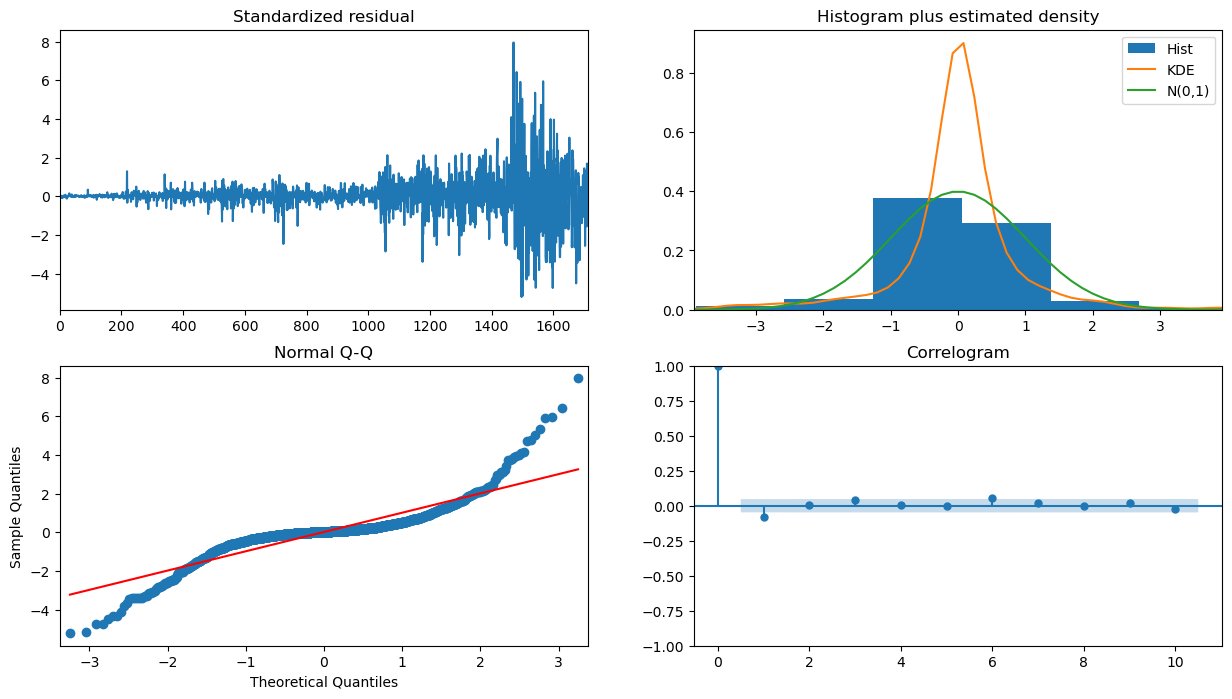

In [19]:
model_autoARIMA = auto_arima(closing_data, trace=True, suppress_warnings=True, stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [29]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(4,1,4))  
fitted = model.fit()  
print(fitted.summary())

/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1540
Model:                 ARIMA(4, 1, 4)   Log Likelihood                3244.560
Date:                Sat, 22 Oct 2022   AIC                          -6471.121
Time:                        18:13:10   BIC                          -6423.071
Sample:                             0   HQIC                         -6453.243
                               - 1540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2826      0.489     -2.625      0.009      -2.240      -0.325
ar.L2         -0.4905      0.875     -0.561      0.575      -2.206       1.225
ar.L3         -0.2038      0.849     -0.240      0.8

/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
pred = fitted.predict(start=start, end=end, type='levels')
pred.index = df.index[start:end+1]
print(pred)

Date
2022-02-11    5.568747
2022-02-14    5.573282
2022-02-15    5.577518
2022-02-16    5.574060
2022-02-17    5.578809
                ...   
2022-10-12    5.575477
2022-10-13    5.575477
2022-10-14    5.575477
2022-10-17    5.575477
2022-10-18    5.575477
Name: predicted_mean, Length: 172, dtype: float64


/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


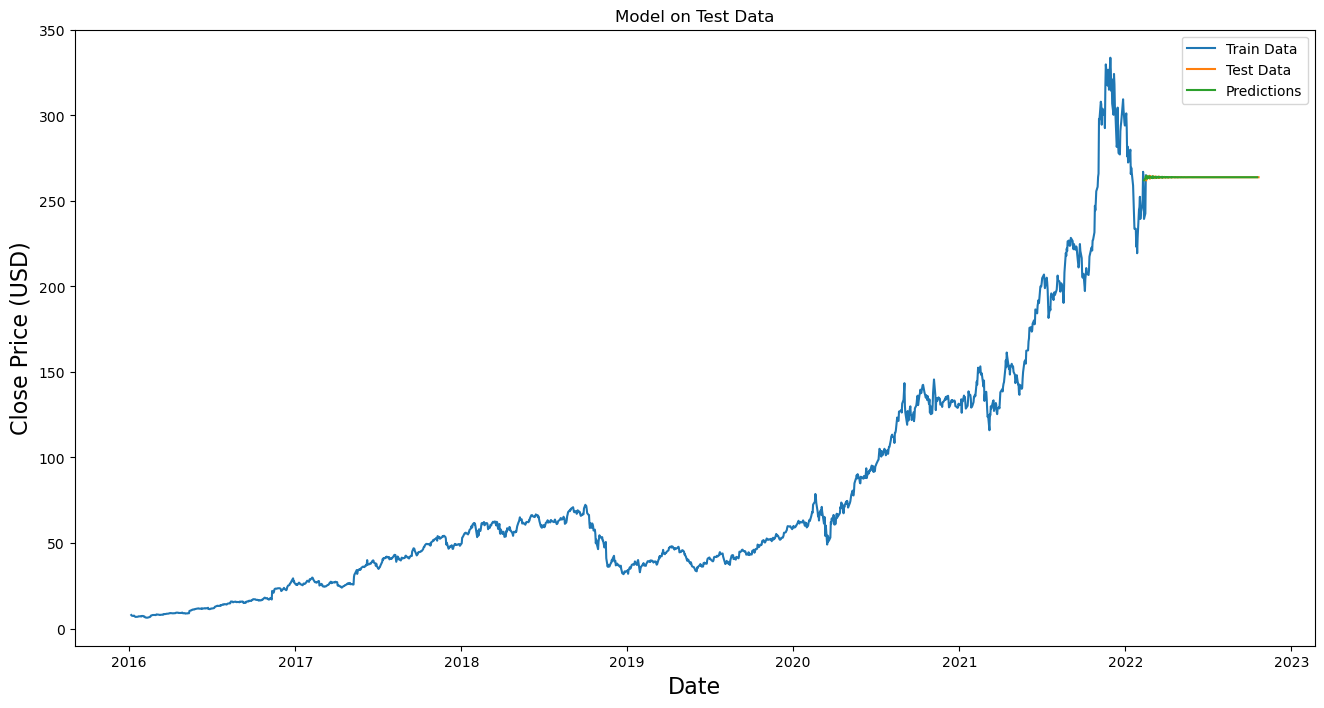

In [45]:
plt.figure(figsize=(16,8))
plt.title('Model on Test Data')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Close Price (USD)', fontsize=16)
plt.plot(np.exp(train_data), label = "Train Data")
plt.plot(np.exp(test_data), label = "Test Data")
plt.plot(np.exp(pred), label = "Predictions")
plt.legend()
plt.show()

In [48]:
forecast_model = ARIMA(closing_data, order = (4,1,4))
forecast_fit = forecast_model.fit()

/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

In [62]:
dates_to_predict = pd.date_range(start="2022-10-24", end="2022-11-04")
pred = forecast_fit.predict(start=len(df), end=len(df)+11).rename("Close Price Predictions")
pred.index = dates_to_predict
print(pred)

2022-10-24    125.187824
2022-10-25    124.262527
2022-10-26    124.521436
2022-10-27    123.877749
2022-10-28    124.677772
2022-10-29    124.564671
2022-10-30    125.083191
2022-10-31    124.602200
2022-11-01    124.449740
2022-11-02    124.159121
2022-11-03    124.278030
2022-11-04    124.674135
Freq: D, Name: Price Predictions, dtype: float64


/Users/bryanwonggy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


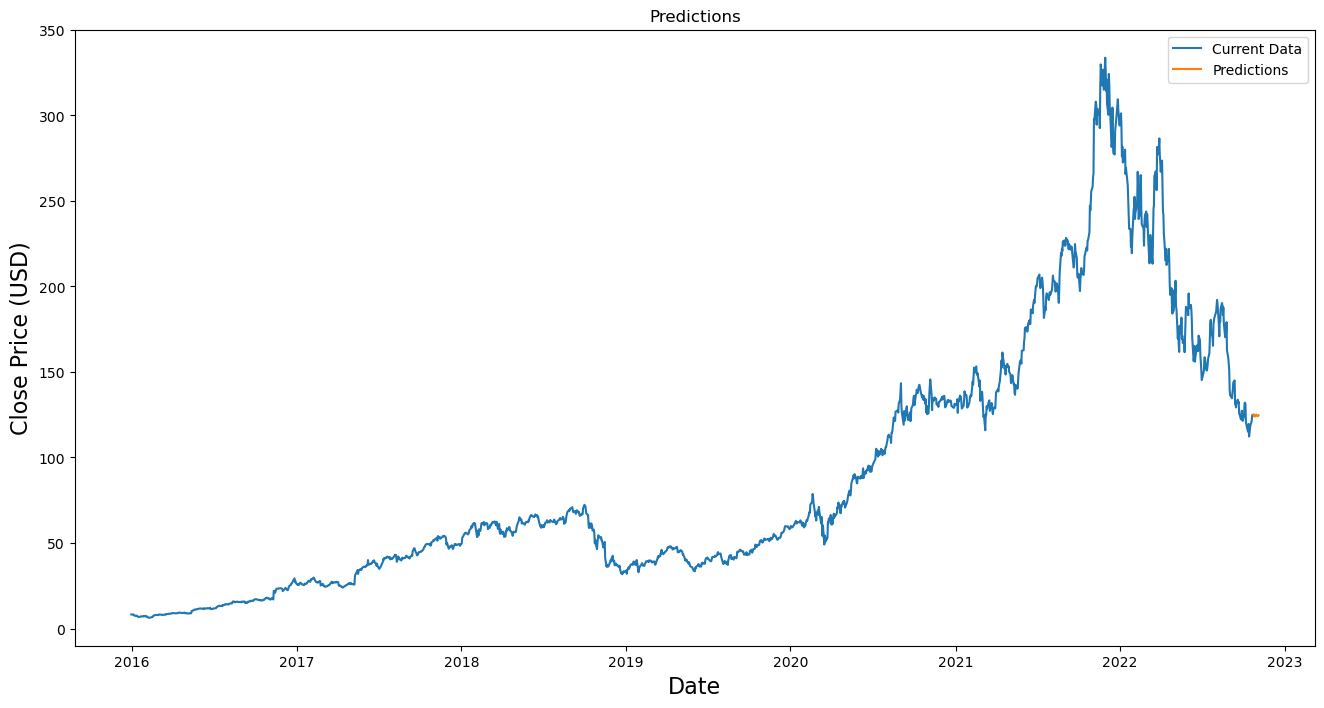

In [63]:
plt.figure(figsize=(16,8))
plt.title('Predictions')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Close Price (USD)', fontsize=16)
plt.plot(df['Close'], label = "Current Data")
plt.plot(pred, label = "Predictions")
plt.legend()
plt.show()

In [65]:
results = pd.DataFrame(pred)
results.to_csv (r'/Users/bryanwonggy/FintechSociety/ML Project 1 - NVDA Price Prediction/BryanWongJunLin_Impl_2.csv', index = True, header=True)